# Understanding Combined Policy in SynPlanner

This tutorial explains how SynPlanner combines **filtering** and **ranking** policies for better retrosynthesis planning.

## Why Two Policies?

| Policy | Training Data | What it Learns | Output |
|--------|--------------|----------------|--------|
| **Filtering** | 600K molecules × 20K rules (multi-label) | "Is this rule applicable?" | Independent probabilities (sigmoid) |
| **Ranking** | 1 positive rule per reaction | "Which rule was actually used?" | Relative ranking (softmax) |

**Key insight**: Filtering knows applicability, Ranking knows feasibility. Combining them gives the best of both!

## 1. Setup

In [1]:
from pathlib import Path
from synplan.utils.loading import download_all_data, load_combined_policy_function
from synplan.chem.utils import mol_from_smiles
from synplan.chem.precursor import Precursor

# Download SynPlanner data
data_folder = Path("synplan_data").resolve()
download_all_data(save_to=data_folder)

filtering_path = data_folder / "uspto/weights/filtering_policy_network.ckpt"
ranking_path = data_folder / "uspto/weights/ranking_policy_network.ckpt"

Fetching 25 files:   0%|          | 0/25 [00:00<?, ?it/s]

## 2. Load Combined Policy

The combined policy uses this formula:
```
combined_logits = filtering_logits + ranking_weight × ranking_logits
combined_probs = softmax(combined_logits / temperature)
```

**Parameters:**
- `ranking_weight > 1.0` → More bias toward ranking (proven reactions)
- `temperature > 1.0` → Softer distribution (more exploration)

In [2]:
# Load combined policy with recommended settings
combined_policy = load_combined_policy_function(
    filtering_weights_path=filtering_path,
    ranking_weights_path=ranking_path,
    top_rules=50,
    ranking_weight=1.0,   # Try 1.5 for more feasibility bias
    temperature=1.0,      # Try 1.2-1.5 for more exploration
)

Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint synplan_data/uspto/weights/filtering_policy_network.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint synplan_data/uspto/weights/ranking_policy_network.ckpt`


## 3. Analyze Policy Distributions

Let's see how the policies behave on a real molecule.

In [3]:
import torch

# Example: Capivasertib (FDA-approved 2023 for breast cancer)
smiles = "NC1(CCN(CC1)C1=C2C=CNC2=NC=N1)C(=O)N[C@@H](CCO)C1=CC=C(Cl)C=C1"
molecule = mol_from_smiles(smiles, standardize=True, clean_stereo=True)
precursor = Precursor(molecule)

# Get logits from both networks
filtering_logits = combined_policy.filtering_net.get_logits(precursor)
ranking_logits = combined_policy.ranking_net.get_logits(precursor)

# Compute probabilities
filtering_probs = torch.sigmoid(filtering_logits)
ranking_probs = torch.softmax(ranking_logits, dim=-1)
combined_logits = filtering_logits + combined_policy.ranking_weight * ranking_logits
combined_probs = torch.softmax(combined_logits / combined_policy.temperature, dim=-1)

print(f"Total rules: {len(filtering_logits)}")
print(f"\nFiltering: mean={filtering_probs.mean():.4f}, max={filtering_probs.max():.3f}")
print(f"Ranking:   mean={ranking_probs.mean():.6f}, max={ranking_probs.max():.3f}")
print(f"Combined:  mean={combined_probs.mean():.6f}, max={combined_probs.max():.3f}")

Total rules: 24094

Filtering: mean=0.0107, max=1.000
Ranking:   mean=0.000042, max=0.968
Combined:  mean=0.000042, max=0.372


## 4. Compare Top Rules from Each Policy

In [4]:
# Get top 10 from each
top_filtering = torch.topk(filtering_probs, 10)
top_ranking = torch.topk(ranking_probs, 10)
top_combined = torch.topk(combined_probs, 10)

print("Top 10 rules by each policy:")
print(f"{'Rank':<5} {'Filtering':<18} {'Ranking':<18} {'Combined':<18}")
print("-" * 60)
for i in range(10):
    f_id, f_p = top_filtering.indices[i].item(), top_filtering.values[i].item()
    r_id, r_p = top_ranking.indices[i].item(), top_ranking.values[i].item()
    c_id, c_p = top_combined.indices[i].item(), top_combined.values[i].item()
    print(f"{i+1:<5} {f_id:>5} ({f_p:.3f})     {r_id:>5} ({r_p:.4f})     {c_id:>5} ({c_p:.3f})")

# Overlap analysis
f_set = set(top_filtering.indices.tolist())
r_set = set(top_ranking.indices.tolist())
c_set = set(top_combined.indices.tolist())

print(f"\nOverlap (top 10):")
print(f"  Filtering ∩ Ranking:  {len(f_set & r_set)} rules")
print(f"  Filtering ∩ Combined: {len(f_set & c_set)} rules")
print(f"  Ranking ∩ Combined:   {len(r_set & c_set)} rules")

Top 10 rules by each policy:
Rank  Filtering          Ranking            Combined          
------------------------------------------------------------
1      1337 (1.000)      2403 (0.9685)         9 (0.372)
2      1207 (1.000)         9 (0.0284)       692 (0.267)
3      5447 (1.000)        68 (0.0015)       596 (0.255)
4       596 (1.000)        72 (0.0003)      1407 (0.101)
5       692 (1.000)       175 (0.0002)       154 (0.003)
6      6389 (1.000)        39 (0.0002)        85 (0.002)
7      8972 (1.000)       154 (0.0002)      4579 (0.000)
8      7850 (1.000)        85 (0.0002)       438 (0.000)
9      6215 (1.000)         3 (0.0001)       828 (0.000)
10     2513 (1.000)       243 (0.0000)       441 (0.000)

Overlap (top 10):
  Filtering ∩ Ranking:  0 rules
  Filtering ∩ Combined: 2 rules
  Ranking ∩ Combined:   3 rules


## 5. Understanding the Results

### What You'll Typically See:

1. **Filtering and Ranking disagree** on top rules (often 0 overlap in top 10!)
   - Filtering: "These rules CAN apply to this molecule"
   - Ranking: "This rule looks like the original reaction" (biased to training data)

2. **Combined finds consensus** - picks rules that BOTH policies consider reasonable

3. **Filtering has veto power** - if filtering says "not applicable" (low logit), the rule won't be selected even if ranking loves it

### Example Interpretation:
- Rule 2403: Ranking gives 96% prob, but filtering says "not applicable" → **Combined rejects it**
- Rule 9: Ranking gives 2.8%, filtering says "applicable" → **Combined accepts it**

## 6. Visualize Distributions

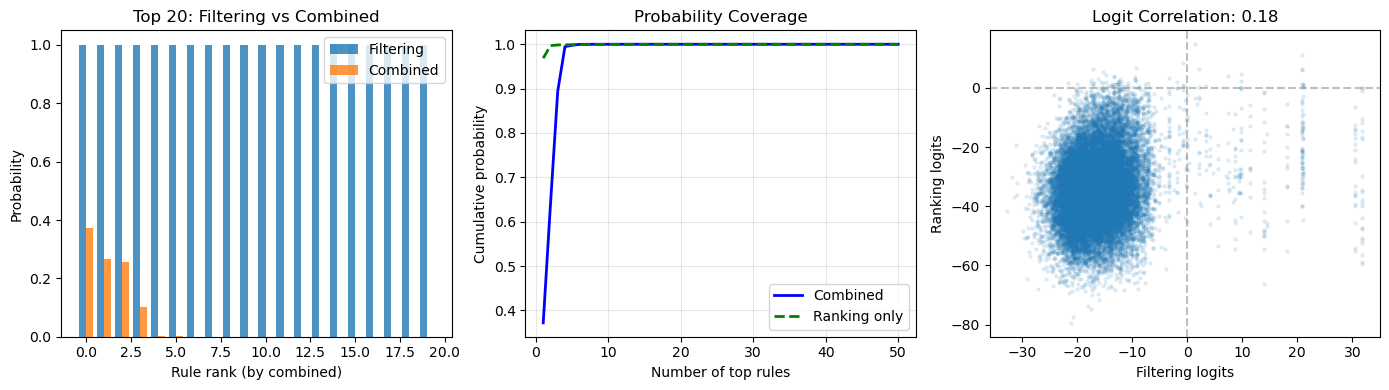

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Get top 50 by combined
top50 = torch.topk(combined_probs, 50)
top50_f = filtering_probs[top50.indices].numpy()
top50_r = ranking_probs[top50.indices].numpy()
top50_c = top50.values.numpy()

# Plot 1: Probability comparison
x = np.arange(20)  # Focus on top 20
axes[0].bar(x - 0.2, top50_f[:20], 0.4, label='Filtering', alpha=0.8)
axes[0].bar(x + 0.2, top50_c[:20], 0.4, label='Combined', alpha=0.8)
axes[0].set_xlabel('Rule rank (by combined)')
axes[0].set_ylabel('Probability')
axes[0].set_title('Top 20: Filtering vs Combined')
axes[0].legend()

# Plot 2: Cumulative probability
cum_combined = np.cumsum(np.sort(combined_probs.numpy())[::-1])
cum_ranking = np.cumsum(np.sort(ranking_probs.numpy())[::-1])
axes[1].plot(range(1, 51), cum_combined[:50], 'b-', lw=2, label='Combined')
axes[1].plot(range(1, 51), cum_ranking[:50], 'g--', lw=2, label='Ranking only')
axes[1].set_xlabel('Number of top rules')
axes[1].set_ylabel('Cumulative probability')
axes[1].set_title('Probability Coverage')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Logit correlation
axes[2].scatter(filtering_logits.numpy(), ranking_logits.numpy(), alpha=0.1, s=5)
axes[2].set_xlabel('Filtering logits')
axes[2].set_ylabel('Ranking logits')
axes[2].set_title(f'Logit Correlation: {torch.corrcoef(torch.stack([filtering_logits, ranking_logits]))[0,1]:.2f}')
axes[2].axhline(0, color='gray', ls='--', alpha=0.5)
axes[2].axvline(0, color='gray', ls='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 7. Tuning Recommendations

### When to Adjust Parameters:

| Problem | Solution |
|---------|----------|
| Routes found but reactions fail in lab | ↑ `ranking_weight` (1.5-2.0) |
| Can't find routes for complex molecules | ↑ `temperature` (1.2-1.5) |
| Too many similar routes | ↑ `temperature` |
| Search is too slow | ↓ `top_rules` (30-40) |

### Recommended Starting Points:

```python
# Balanced (default)
ranking_weight=1.0, temperature=1.0

# Better feasibility
ranking_weight=1.5, temperature=1.0

# More exploration
ranking_weight=1.0, temperature=1.5

# Recommended for difficult molecules
ranking_weight=1.5, temperature=1.2
```

## 8. Key Takeaways

1. **Filtering = Applicability Gate**
   - Trained on multi-label data (which rules CAN apply)
   - Has "veto power" - very negative logits block a rule

2. **Ranking = Feasibility Ranking**
   - Trained on actual reactions (which rule WAS used)
   - Biased toward training distribution, but knows what "works"

3. **Combined = Best of Both**
   - Filtering gates out non-applicable rules
   - Ranking ranks the remaining by feasibility
   - Low correlation (0.1-0.3) means they capture different aspects

4. **Don't Normalize Logits**
   - The scale difference is intentional
   - Filtering needs absolute values for veto power
   - Use `ranking_weight` to tune relative importance